In this module, we study how to implement the tree-based algorithms for regression tasks in Python. The note made here will be extremely similar to the previous script on tree-based classification. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import graphviz # conda prompt: conda install python-graphviz

from IPython.display import Image  
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import export_graphviz

%matplotlib inline

In [2]:
path='C:\\Users\\pgao\\Documents\\PGZ Documents\\Programming Workshop\\PYTHON\\Open Courses on Python\\Udemy Course on Python\\Introduction to Data Science Using Python\\datasets'
os.chdir(path)
df = pd.read_csv('loan_data.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB
None


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


Now let's do some explorative analysis. Let's create a histogram of two FICO distributions on top of each other, one for each credit.policy outcome:

Text(0.5,0,'FICO')

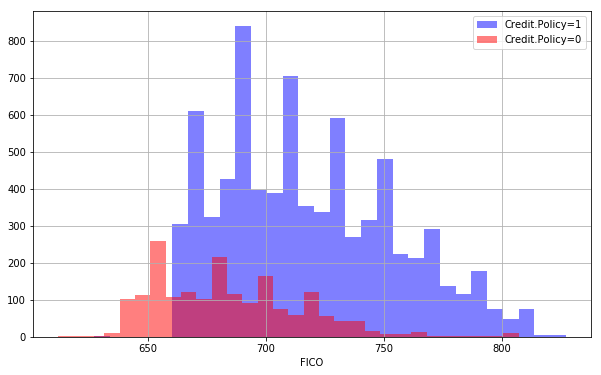

In [3]:
plt.figure(figsize=(10,6))
df[df['credit.policy']==1]['fico'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Credit.Policy=1')
df[df['credit.policy']==0]['fico'].hist(alpha=0.5,color='red',
                                              bins=30,label='Credit.Policy=0')
plt.legend()
plt.xlabel('FICO')

Let's see the trend between FICO score and interest rate:

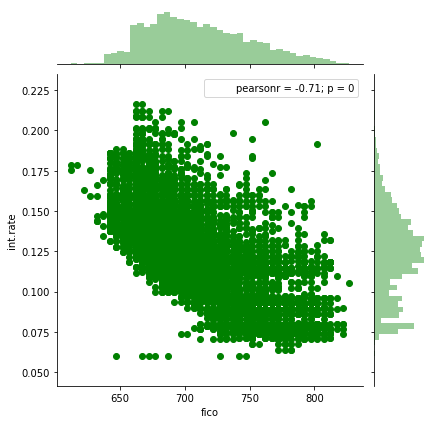

In [4]:
sns.jointplot(x='fico',y='int.rate',data=df,color='green')

We want to use all the features to predict FICO score (fico). Let's clean the data first. Notice that the variable 'purpose' is categorical, so we need to convert them into numeric values. All the tree-based algorithms require numeric inputs. And keep in mind that when we convert dummies, we do not need worry about the dummy variable trap (this is different from the case in linear models where multicollinearity is an issue):

In [5]:
dummies = pd.get_dummies(df['purpose'])
df = pd.concat([df, dummies], axis=1)  
df.drop(['purpose'], inplace=True, axis=1)     
varlist=list(df.columns)
print('Variable list: \n', varlist)

Variable list: 
 ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid', 'all_other', 'credit_card', 'debt_consolidation', 'educational', 'home_improvement', 'major_purchase', 'small_business']


Now for simplicity and illustrative purpose, let's drop a few variables to make our final model presentation more parsimonious:

In [6]:
df.drop(['small_business', 'major_purchase', 'home_improvement', 'all_other', 'not.fully.paid'], inplace=True, axis=1)

In [7]:
EDA1=df.describe()
EDA2=df.columns
print(EDA1, '\n')
print(EDA2, '\n')

       credit.policy     int.rate  installment  log.annual.inc          dti  \
count    9578.000000  9578.000000  9578.000000     9578.000000  9578.000000   
mean        0.804970     0.122640   319.089413       10.932117    12.606679   
std         0.396245     0.026847   207.071301        0.614813     6.883970   
min         0.000000     0.060000    15.670000        7.547502     0.000000   
25%         1.000000     0.103900   163.770000       10.558414     7.212500   
50%         1.000000     0.122100   268.950000       10.928884    12.665000   
75%         1.000000     0.140700   432.762500       11.291293    17.950000   
max         1.000000     0.216400   940.140000       14.528354    29.960000   

              fico  days.with.cr.line     revol.bal   revol.util  \
count  9578.000000        9578.000000  9.578000e+03  9578.000000   
mean    710.846314        4560.767197  1.691396e+04    46.799236   
std      37.970537        2496.930377  3.375619e+04    29.014417   
min     612.0000

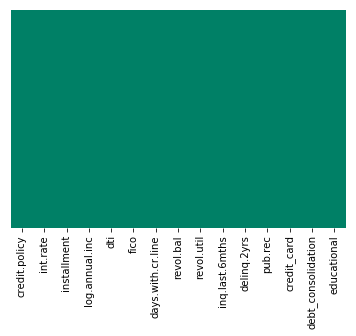

In [8]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False, cmap='summer')

Now let's do the training test split:

In [9]:
X = df.drop('fico',axis=1)
y = df['fico']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

We now perform our analysis in the following manner: 1) off-the-shelves regression tree, 2) extra tree (extremely randomized tree), 3) bagged tree and 4) random forests. 

First, we use the off-the-shelves regression tree. The default impurity function is given by the Gini index. The 'scikit-learn' package uses an optimized version of the CART algorithm.

In [10]:
rtree = DecisionTreeRegressor(max_features=4, max_depth=8)
rtree.fit(X_train,y_train)
predictions = rtree.predict(X_test)
print('Regression Tree MSE:', metrics.mean_squared_error(y_test, predictions))

Regression Tree MSE: 488.870153231


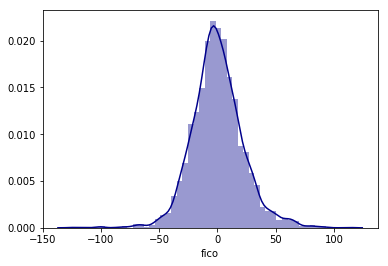

In [11]:
sns.distplot((y_test-predictions),bins=50, color='darkblue')

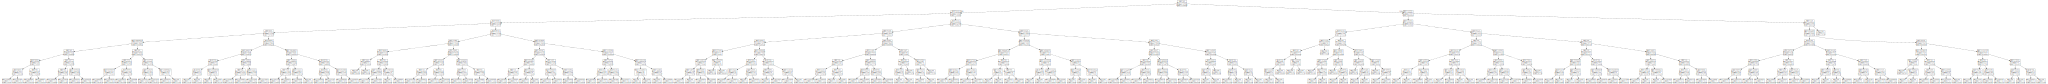

In [12]:
dot_data = export_graphviz(rtree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

Next let's examine the extremely randomized tree method. This algorithm implements a meta estimator that fits a number of randomized regression trees (a.k.a. extra-trees) on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. Some of the arguments for the ExtraTreesRegressor() method include the following: 

  1. n_estimators: integer, optional (default=10)
  2. criterion: string, optional (default="mse", and the alternative is "mae", both of which measures the impurity functions (quality of theh split)
  3. max_features: int, float, string or None, optional (default=None)
  
The maximum feature determines the number of features to consider when looking for the best split. Having a value of 'int' considers 'max_features' features at each split. Having a value of 'float' implies that 'max_features' is a percentage and int(max_features * n_features) features are considered at each split. If 'auto', then max_features=n_features. This is very similar to the case for classification. If None, then max_features=n_features.

There are many other optional arguments for this method which can be found in the online documentation. 

Now let's apply this method to the same dataset and compare. We see immediately that the extra tree method reduces the MSE:

In [13]:
extratree = ExtraTreesRegressor(max_features=7)
extratree.fit(X_train,y_train)
predictions = extratree.predict(X_test)
print('Regression Tree MSE:', metrics.mean_squared_error(y_test, predictions))

Regression Tree MSE: 334.059151009


If you would like to see how each tree is performed, you can do the following:

In [14]:
extratree.estimators_

[ExtraTreeRegressor(criterion='mse', max_depth=None, max_features=7,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=941405880,
           splitter='random'),
 ExtraTreeRegressor(criterion='mse', max_depth=None, max_features=7,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=1538613272,
           splitter='random'),
 ExtraTreeRegressor(criterion='mse', max_depth=None, max_features=7,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=224608728,
           splitter='random'),
 ExtraTreeRegressor(criterion='mse', max_depth=None, max_features=7,
           max_leaf_nodes=N

The extra tree method is hard to visualize given the random nature of the algorithm (because there are more than one trees). However, practioners often use this method to rank variable importance. 

The features to be scored include the following in order:  ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'credit_card', 'debt_consolidation', 'educational'] 

credit.policy : 0.0812118238748
int.rate : 0.361559830091
installment : 0.0677026529862
log.annual.inc : 0.0288516225694
dti : 0.0340078283093
days.with.cr.line : 0.0560350231523
revol.bal : 0.0333693493543
revol.util : 0.229225237763
inq.last.6mths : 0.0346305070541
delinq.2yrs : 0.0378962770813
pub.rec : 0.010048401542
credit_card : 0.00670149091332
debt_consolidation : 0.0149992690444
educational : 0.0037606862646

 Feature ranking:
1. feature 1 (0.361560)
2. feature 7 (0.229225)
3. feature 0 (0.081212)
4. feature 2 (0.067703)
5. feature 5 (0.056035)
6. feature 9 (0.037896)
7. feature 8 (0.034631)
8. feature 4 (0.034008)
9. feature 6 (0.033369)
10. feature 3 (0.028852)
11. feature 12 (0.014999)
12. feature 10 (0.

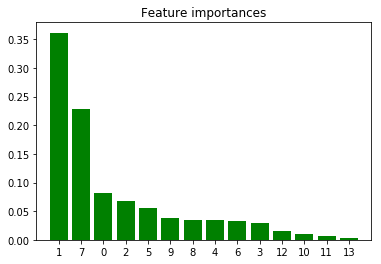

In [15]:
Xcolumn_names=list(X_train)
importances = extratree.feature_importances_
feature_report = dict(zip(Xcolumn_names, importances))
print('The features to be scored include the following in order: ', Xcolumn_names, '\n')
for j in feature_report:
    print (j,':',feature_report[j])    
    
std = np.std([extratree.feature_importances_ for tree in extratree.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
print("\n Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="green", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

The third algorithm we will go over is the tree-bagging algorithm for regression. The main function we will be using is BaggingRegressor(). Bagging originally denotes bootstrap aggregating. Here, the BaggingRegressor() is actually a more general regression model than the originally proposed tree-bagging regression algorithm. In Python specifically, BaggingRegressor() can be encapsulated as an ensemble meta-estimator that fits base models each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a regression tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

This BaggingRegressor() algorithm in Python encompasses several works from the literature. When random subsets of the dataset are drawn as random subsets of the samples, then this algorithm is known as 'Pasting'. If samples are drawn with replacement (through bootstrap), then the method is known as 'Bagging' (this is the original bagging). When random subsets of the dataset are drawn as random subsets of the features, then the method is known as 'Random Subspaces'. Finally, when base estimators are built on subsets of both samples and features, then the method is known as 'Random Patches'. The online documentation provides all the details of these algorithms and their sources from academic papers. Basically, the key here is that BaggingRegressor() not only includes the tree-bagging algorithm proposed by Breiman (1996) in his paper 'Bagging Predictors'. 

The BaggingRegressor() function provides a set of arguments. Here are some highlights:

  1. base_estimator: object or None, optional (default=None)
  2. n_estimators: int, optional (default=10)
  3. max_samples: int or float, optional (default=1.0)
  4. bootstrap: (default=True)
  5. bootstrap_features: (default=False)

For (1), the base estimator to fit on random subsets of the dataset. If the value is set 'None', then the base estimator is a decision tree. For (2), the n_estimators is the number of base estimators in the ensemble. For (3), max_samples is the number of samples to draw from X to train each base estimator. In particular:

  1. If 'int', then draw max_samples samples.
  2. If 'float', then draw max_samples * X.shape[0] samples.
  
For (5), the argument controls whether features are drawn with replacement. Again, there are many more arguments not discussed but can be found from the online documentation. 

There are also many methods associated with this algorithm. For example, score(X, y, sample_weight=None) returns the average accuracy on the given dataset and labels. For another example, predict_proba(X) can also predict class probabilities for X. The predicted class probabilities of an input sample is computed as the mean predicted class probabilities of the base estimators in the ensemble. 

Below, let's create an example of using BaggingRegressor() with 100 trees and CART as the base estimator:

In [16]:
CART = DecisionTreeRegressor()
seed=53964
num_trees = 500
btree = BaggingRegressor(base_estimator=CART, n_estimators=num_trees, random_state=seed)
btree.fit(X_train,y_train)
predictions = btree.predict(X_test)
print('Regression Tree MSE:', metrics.mean_squared_error(y_test, predictions))

Regression Tree MSE: 286.838939109


The BaggingRegressor() does not have the feature importance mechanism to help us select variables. 

Lastly, let's go over random forests. A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

The syntax for RandomForestRegressor() is extremely similar to the previous three algorithms so we will not elaborate here, and any confusions can be cleared by referencing the online documentation. The nice thing about this function is that it has the attribute 'feature_importances_'.

In [17]:
rftree = RandomForestRegressor()
rftree.fit(X_train,y_train)
predictions = rftree.predict(X_test)
print('Regression Tree MSE:', metrics.mean_squared_error(y_test, predictions))

Regression Tree MSE: 319.212682672


The features to be scored include the following in order:  ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'credit_card', 'debt_consolidation', 'educational'] 

credit.policy : 0.0191625607526
int.rate : 0.598878658551
installment : 0.103807244032
log.annual.inc : 0.0224877166117
dti : 0.039482182612
days.with.cr.line : 0.0520109617196
revol.bal : 0.0298942925182
revol.util : 0.0925181901336
inq.last.6mths : 0.0213884837552
delinq.2yrs : 0.0121414696335
pub.rec : 0.00183858647043
credit_card : 0.00138073552348
debt_consolidation : 0.00442608146399
educational : 0.000582836222336

 Feature ranking:
1. feature 1 (0.598879)
2. feature 2 (0.103807)
3. feature 7 (0.092518)
4. feature 5 (0.052011)
5. feature 4 (0.039482)
6. feature 6 (0.029894)
7. feature 3 (0.022488)
8. feature 8 (0.021388)
9. feature 0 (0.019163)
10. feature 9 (0.012141)
11. feature 12 (0.004426)
12. feature 10

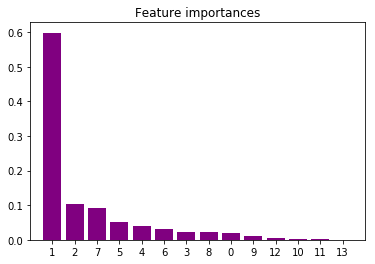

In [21]:
Xcolumn_names=list(X_train)
importances = rftree.feature_importances_
feature_report = dict(zip(Xcolumn_names, importances))
print('The features to be scored include the following in order: ', Xcolumn_names, '\n')
for j in feature_report:
    print (j,':',feature_report[j])    
    
std = np.std([rftree.feature_importances_ for tree in rftree.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
print("\n Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="purple", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Additional resources:
  - https://stackoverflow.com/questions/38108832/passing-categorical-data-to-sklearn-decision-tree
  - https://stats.stackexchange.com/questions/177852/best-practices-for-coding-categorical-features-for-decision-trees
  - https://stackoverflow.com/questions/36631163/pandas-get-dummies-vs-sklearns-onehotencoder-what-is-more-efficient
  - http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
  - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html
  - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html 
  - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html